# Monte Carlo

Monte Carlo is a method for policy control/estimation that is based on optimizing a long time reward.

That is, a reward of a pair state-action $(S_t,a)$ will be expected to be: 

$G_t = R_t + \gamma R_{t+1} + \gamma^2R_{t+2} + \dots + \gamma^{T-t} R_T$

Where $\gamma$ is the discount factor of a reward.

The optimal policy $\pi$ will be greedy according $q(S, a)$:

$\pi(S) = \underset{a}{\text{argmax}}\ q(S, :)$

## Initial Imports


In [108]:
import numpy as np
import itertools
import random
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import os
import sys

## Monte Carlo Methods

In [109]:
sys.path.append( os.path.join('..') )
from RLearning.envrioments import SimplifiedBlackjack
from RLearning.monte_carlo import MonteCarlo

### Example - 'Pseudo' Blackjack

This example implements Monte Carlo Algorithm to solve the Blackjack problem with the following considerations:

- Optimizing the state and state-action iteratively

Training the model

In [110]:
%%time
montecarlo = MonteCarlo( episodes=50000000, eps=0.001 )
envrioment = SimplifiedBlackjack( )
montecarlo.fit( envrioment )

CPU times: total: 1h 2min 11s
Wall time: 1h 33min 43s


Visualizing the resulting policy

In [111]:
states = envrioment.states
state_to_id = montecarlo.env_interface._state_to_id

policy = { state:montecarlo.env_interface.choose_greedy_action( state_to_id[state] ) for state in states }

Text(0.5, 0.98, 'Policy for each state')

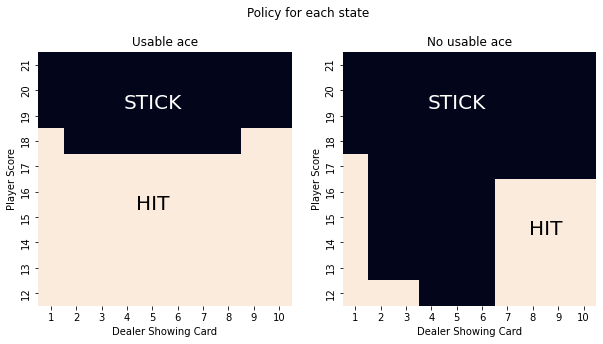

In [112]:
policy_df = np.c_[ np.array( list(policy.keys()  ) ), 
                   np.array( list(policy.values()) ) ]

policy_df = pd.DataFrame( policy_df, columns=['Player Score', 
                                              'Dealer Showing Card', 
                                              'Player Has Ace', 
                                              'action'] 
                         )


policy_ace = ( policy_df.query("`Player Has Ace`==1")
               .pivot( 'Player Score', 'Dealer Showing Card', 'action' )
               .sort_values('Player Score', ascending=False)
             )
policy_no_ace = ( policy_df.query("`Player Has Ace`==0")
                  .pivot( 'Player Score', 'Dealer Showing Card', 'action' )
                  .sort_values('Player Score', ascending=False)
                )


fig, ax = plt.subplots( figsize=(10,5), ncols=2 )
sns.heatmap(data = policy_ace,
            ax=ax[0],
            square=True,
            cbar=False
           )
sns.heatmap(data=policy_no_ace,
            ax=ax[1],
            square=True,
            cbar=False
           )

ax[0].set_title("Usable ace")
ax[1].set_title("No usable ace")

ax[0].text( 4.5, 2, "STICK", ha='center', va='center', color='w', fontsize=20 )
ax[0].text( 4.5, 6, "HIT", ha='center', va='center', color='k', fontsize=20 )

ax[1].text( 4.5, 2, "STICK", ha='center', va='center', color='w', fontsize=20 )
ax[1].text( 8, 7, "HIT", ha='center', va='center', color='k', fontsize=20 )

fig.suptitle( "Policy for each state" )

## Monte Carlo without exploring starts


### On-Policy

Estimate a soft policy $\pi$ such that $\pi(a|S_t) > 0 \ \forall a\in A$.

The discussed method is the $\varepsilon$-greedy method, where
the policy $\pi$ behavior as follows

$
\pi(a, S) = 
\left\{\begin{matrix}
 1-\varepsilon& \text{To select the best action} \\ 
 \varepsilon& \text{To select a random action}  
\end{matrix}\right.
$

This means that each non-optimal action has a probability of $\frac{\varepsilon}{|A(S)|}$ of being selected.

## Example - Racetrack

Implementing the racetrack

In [64]:
TRACK = 0
OFF_TRACK = 1
START = 2
FINISH = 3
TOP_SPEED = 5

class Racetrack():
  def __init__(self, nlin=40, ncol=40):
    self._create_track(nlin, ncol)
    self.initialize_states()
    self.initialize_actions()
    self.initalize_scores()

  def _check_map_limits(self, line, column):
    '''
    Check if the coordinate is in the matrix limits
    '''
    if not ( line<self.racetrack.shape[0] and column<self.racetrack.shape[1] ):
      return False # Check map limits
    if not ( line>=0 and column>=0 ):
      return False # Check map limits

    return True

  def _check_track(self, line, column):
    '''
    Defines the track structure 
    '''
    l = line
    c = column
    if not ( (l+c > 20 and l+c < 45) and not ( l>8 and c>20 ) ):
      return False # Check track
    return self._check_map_limits(line, column)
  
  def _create_track(self, nlin, ncol):
    '''
    Create a matrix describing the track structure
    '''
    self.racetrack = np.zeros( (nlin, ncol) )
    self.racetrack[:,:] = OFF_TRACK
    
    for l in range( nlin ):
      for c in range( ncol ):
        if self._check_track(l, c):
          self.racetrack[l][c] = TRACK
          if c==ncol-1:
            self.racetrack[l][c] = FINISH
          if l==nlin-1:
            self.racetrack[l][c] = START
  
  def initialize_states(self):

    # The states are all valid positons with all valid speeds + terminal state
    valid_positions = np.argwhere( self.racetrack != OFF_TRACK ).tolist()
    speeds = np.array( 
                      list( 
                           itertools.product( 
                                             range(0,TOP_SPEED+1), 
                                             repeat=2
                                            ) 
                          ) 
                     ).tolist()
    
    # Defining states
    self._id_to_state = dict( 
                             enumerate( 
                                       itertools.product(
                                                         valid_positions, 
                                                         speeds
                                                        )
                                      ) 
                            )
    self._state_to_id = {
                          ( tuple(state[0]), tuple(state[1]) ):id 
                          for id,state in self._id_to_state.items() 
                        }
                        
    self.terminal_state = -1
    self.states = [ i-1 for i in range( 0, len(self._state_to_id)+1 ) ]
    
    # Starts and finishing positions
    self._starts = np.argwhere( self.racetrack == START ).tolist()
    self._finishes = np.argwhere( self.racetrack == FINISH )

    self._finish_line_start = np.min( self._finishes[:,0] )
    self._finish_line_end = np.max( self._finishes[:,0] )
    self._finish_line_col = self._finishes[0,1]
    self._finishes = self._finishes.tolist()

  def initialize_actions(self):
    self.actions = [ i for i in range(9) ]
    self._id_to_action = dict( 
                              enumerate( 
                                         itertools.product(
                                                           [-1,0,1], 
                                                           repeat=2
                                                          ) 
                                         ) 
                             )
  
  def random_start_position(self):
    '''
    Puts the player in a random start position
    '''
    self.position = self._starts[ np.random.randint(0, len(self._starts)) ].copy()

  def initalize_scores(self):
    self.scores = []

  def initialize(self):
    self.random_start_position()
    self.speed = [0,0]
    self._player_in_game = True
    self.scores.append( 0 )

    if len( self.scores )%100000==0:
      print( f"Train n° {len( self.scores )}" )

  def state(self):
    if not self._player_in_game:
      return self.terminal_state

    return self._state_to_id[ ( tuple(self.position), tuple(self.speed) ) ]

  def _check_victory(self):
    return (self.position[0] >= self._finish_line_start 
            and self.position[0] <= self._finish_line_end
            and self.position[1] >= self._finish_line_col
            )

  def reward(self, action, random_increments=True):
    # Decoding action
    action = self._id_to_action[ action ]

    self.position[0] -= self.speed[0]
    self.position[1] += self.speed[1]

    acceleration = list(action)
    # With p=0.1, the speed increment is zero
    if random_increments and np.random.uniform(0,1) < 0.1:
      acceleration[0] = 0
      acceleration[1] = 0

    # Update speeds based on acceleration
    new_speed_0 = max(0, min(TOP_SPEED, self.speed[0]+acceleration[0]) )
    new_speed_1 = max(0, min(TOP_SPEED, self.speed[1]+acceleration[1]) )
    
    # Both speeds cannot be 0
    if new_speed_0 == 0 and new_speed_1 == 0:
      if np.random.randint( 0, 1+1 ) == 0:
        new_speed_0 = max( 1, self.speed[0] )
      else:
        new_speed_1 = max( 1, self.speed[1] )
    self.speed[0] = new_speed_0
    self.speed[1] = new_speed_1

    # Checking victory
    if self._check_victory():
      self._player_in_game = False

      self.scores[-1] += 1
      return 1
    
    # Checking colision
    if not self._check_track( self.position[0], self.position[1] ):
      self.random_start_position()
    
    self.scores[-1] += -1
    return -1

  def is_terminal(self):
    return not self._player_in_game

Creating and visualizing the racetrack

In [65]:
racetrack = Racetrack()

C:\Users\JoãoPedro\AppData\Local\Temp\ipykernel_5340\2346168526.py:12: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


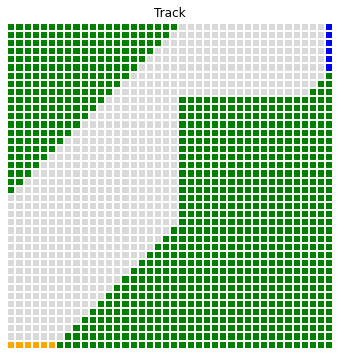

In [66]:
fig, ax = plt.subplots( figsize=(6,6) )
track_cmap = ['#d9d9d9', 'green', 'orange', 'blue']
sns.heatmap(racetrack.racetrack, square=True, cbar=False, 
            cmap=track_cmap, 
            linewidth=.005,
            ax=ax 
            )

ax.axis("off")
ax.set_title("Track")

fig.show()

Training the MonteCarlo player

In [ ]:
%%time
mc_pilot = MonteCarlo( eps=0.1, episodes=5000000 )
mc_pilot.fit( racetrack )

Text(0.5, 1.0, 'Score evolution in each episode')

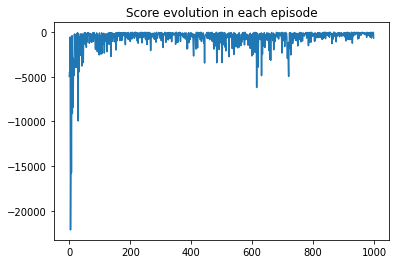

In [101]:
fig, ax = plt.subplots()
ax.plot( racetrack.scores[:1000] )

ax.set_title("Score evolution in each episode")

Visualizing paths

In [92]:
racetrack.initialize()
actions = []
states = []
rewards = []
## Playing the game
time = 0
while True:
  state = mc_pilot.env_interface.state(  )
  action = mc_pilot.env_interface.choose_greedy_action(state)
  reward = mc_pilot.env_interface.reward(action)

  if mc_pilot.env_interface.is_terminal():
    break
  rewards.append( reward )
  states.append( racetrack._id_to_state[ state ] )
  actions.append( action )
  time+=1

Defining speed colors

In [93]:
def transform_color_tuple_into_hex(color):
  color = ( int(255*color[0]), int(255*color[1]), int(255*color[2]) )
  return "#{:02x}{:02x}{:02x}".format(*color)

In [94]:
speed_l_colors = sns.color_palette( 'Reds', n_colors=TOP_SPEED+1 )
speed_c_colors = sns.color_palette( 'Blues', n_colors=TOP_SPEED+1 )
speed_colors = []
speed_to_id = dict()

for i, speed in enumerate( itertools.product( range(TOP_SPEED+1), repeat=2 ) ):
  speed_colors.append( tuple(
                             (speed[0]*np.array(speed_l_colors[speed[0]])+
                              speed[1]*np.array(speed_c_colors[speed[1]])
                              )/(speed[0]+speed[1])
                             )
                       if speed[0]+speed[1] != 0
                       else 
                       tuple(
                             np.array(speed_l_colors[speed[0]])/2+
                             np.array(speed_c_colors[speed[1]])/2
                            )
                     )
  speed_to_id[speed] = i


speed_palette = list(sns.color_palette( speed_colors ).as_hex())

In [95]:
track = np.zeros( racetrack.racetrack.shape )
for position, speed in states:
  track[ tuple(position) ] = speed_to_id[ tuple(speed) ]

Visualizing the track with the player's speed 

C:\Users\JoãoPedro\AppData\Local\Temp\ipykernel_5340\3217729954.py:21: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


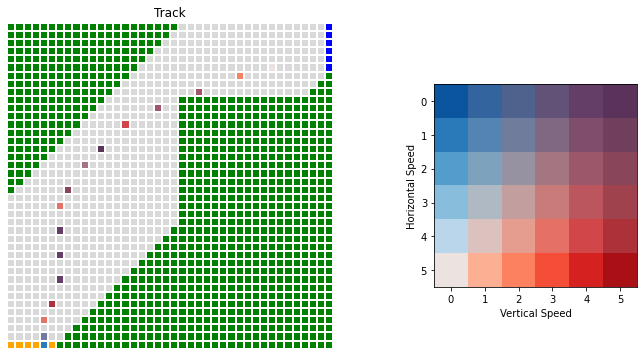

In [96]:
fig, ax = plt.subplots( figsize=(12,6), ncols=2, gridspec_kw={'width_ratios': [2, 1]} )
sns.heatmap(racetrack.racetrack, square=True, cbar=False, 
            cmap=track_cmap, 
            linewidth=.005,
            ax=ax[0]
            )

sns.heatmap(track, square=True, cbar=False, 
            mask=(track == 0),
            cmap=speed_palette, 
            linewidth=.005,
            ax=ax[0]
            )

ax[0].axis("off")
ax[0].set_title("Track")

ax[1].imshow( np.rot90( np.array(speed_colors).reshape((TOP_SPEED+1,TOP_SPEED+1,3)) ) )
ax[1].set_xlabel("Vertical Speed")
ax[1].set_ylabel("Horizontal Speed")
fig.show()